# Softmax regression for handwritten digits

Today, we'll implement a softmax classifier recognizing handwritten digits.  We'll begin by using a relatively small collection (around 1800) of low resolution (8 by 8pix) digits.  This can be easily acquired using scikit-learn.

By: Calvin, Claire, Courtenay

In [7]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
digits = load_digits()

In [8]:
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

The digits appear as an $m\times n$ array, where $m$ is the number of data instances and $n$ is the number of features.  It's important to recognize that for this problem, the number of features is $8\times8 = 64$: the instances are flattened.  If you want to plot a digit from the dataset using, for example, matplotlib's imshow, you'll need to reshape this.  

You'll also want to be careful to normalize the data, preferably by subtracting the mean and dividing by the standard deviation.  

In [9]:
#! Perform normalization
X = digits['data']
Y = digits['target']
X -= X.mean()
X /= X.std()

The labels appear as integers.  Write and apply a function that converts from this integer representation to a one-hot encoding.

In [10]:
#! Convert the labels to a one-hot encoding
print(Y.size)
one_hot = np.zeros((Y.size, Y.max()+1))
one_hot[np.arange(Y.size), Y] = 1
one_hot    

1797


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

Another important step is to split the dataset into training and testing sets.  I like using the function sklearn.model_selection.train_test_split

In [11]:
#! Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test = tts(X,one_hot)
np.shape(y_test)

(450, 10)

With data in hand, we now need to implement the model.  Recall that our predictions will be computed as
$$
Y_{pred} = \mathrm{Softmax}(\Phi W)
$$
Implement the softmax method, generate the matrix $\Phi$ (I suggest a linear model, which is to say that all you need to do will be to prepend a column of ones to the $m\times n$ matrix of pixel values, and instantiate the parameter matrix $W$ (I suggest instantiating to an array of very small random numbers).  Your implementation of Softmax should be vectorized, in that it should take a $m \times N$ array of logits and output and $m \times N$ array without using a loop.  Make a prediction using this untrained model: a sensible result at this stage is that all classes are approximately equally likely.

In [12]:
W = np.random.rand(np.shape(X)[1]+1, Y.max()+1)
def Softmax(Phi, W):
    j = np.sum(np.exp(Phi@W), axis = 1, keepdims=True)
    k = np.exp(Phi@W)
    return k/j
def phi(X):
    new_col = np.ones((len(X),1))
    return np.hstack((new_col, X))

In [13]:
np.sum(Softmax(phi(X),W),axis=1)


array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
np.shape(W)

(65, 10)

Now generate functions (or one function with multiple outputs) to compute the categorical cross entropy and its gradient.  These are given by 
$$
\mathcal{L}(W,\Phi,Y_{obs}) = -\frac{1}{mN} \sum_{i=1}^m \left(Y_{obs,i} \ln \mathrm{Softmax}(\Phi W)\right).
$$
and 
$$
\frac{ \partial \mathcal{L}}{\partial W} = -\frac{1}{mN} \sum_{i=1}^m \left[(Y_{obs,i} - \mathrm{Softmax}(\Phi W)_i) \Phi_i^T\right]^T. 
$$
As you implement these functions, consider how to do so in as efficient a manner as possible.  Note that it is possible to vectorize the sums.    

In [15]:
def L (W, Phi, Y):
    return -1/(len(Y)*Y.max())*np.sum(Y*np.log(Softmax(Phi,W)))
def dldw(W, Phi, Y):
    dif = Y-Softmax(Phi,W)
    m = len(dif)
    gradw = 0
    for i in range(m):
        set1 = np.array([dif[i]])
        set2 = np.array([Phi[i]])
        gradw +=(set1.T*set2).T
       
    return -1/(len(Y)*Y.max())*gradw

In [16]:
np.shape(dldw(W,phi(X),one_hot))
np.shape(W)
#np.outer

(65, 10)

Implement gradient descent and train this model.  Record the value of $\mathcal{L}$ as a function of gradient descent iteration, and produce a plot convincing yourself that the model is converging to a minimum.

One very interesting result of working with image data is that we can interpret the learned parameters as images (the weight matrix is $N\times (1+n)$.  If you get rid of the first entry, which corresponds to a constant offset, the remaining $N \times n$ weights are each associated with a given input pixel for a given class).  Plot your weights as images (there should be ten of them).  Evaluate the pattern that you find.    

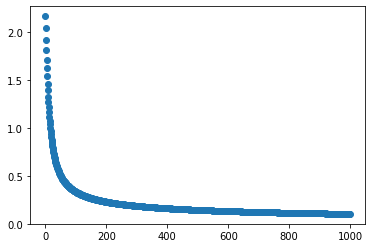

In [17]:
W = np.random.rand(np.shape(X)[1]+1, Y.max()+1)*1e-4
def W_closer(W,Phi,Y, n=1e-1 ):
    return W -n*dldw(W,Phi,Y)
def train_model(W,X,Y,itera=10):
    Phi = phi(X)
    plot1=[]
    plot2=[]
    for i in range(itera):
        plot1.append(i)
        W = W_closer(W,Phi,Y)
        plot2.append(L(W,Phi,Y))        
    plt.scatter(plot1,plot2)
    plt.show()
    return W
w = train_model(W, x_train, y_train,itera=1000)

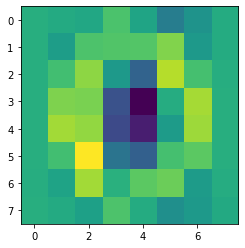

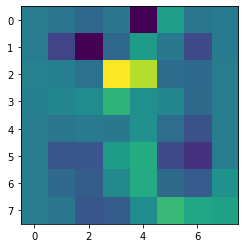

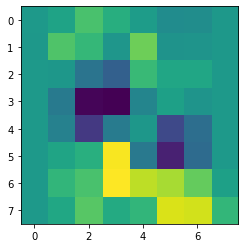

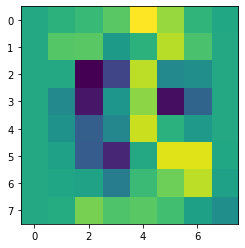

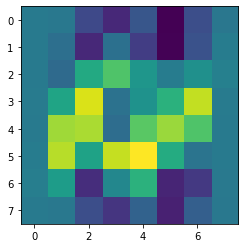

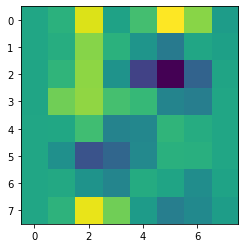

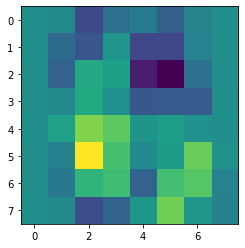

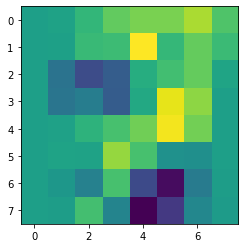

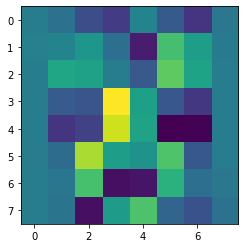

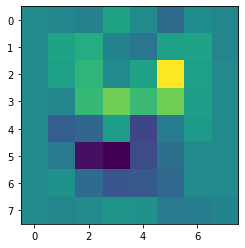

In [18]:
import matplotlib.image as img
plot3 = []
for i in range(10):
    plot3.append(w.T[i][1:])
for i in range(10):
    plt.imshow(np.reshape(plot3[i],(8,8)))
    plt.show()


The pattern we see above begins to resemble the nu,ber each section represents, this is clear especially for the zero image, the seven image, the five image, the eight image and the nine image.

Finally, once this task is complete, scale your method up to the larger (in both number of instances and resolution) dataset MNIST (you can get it using the command sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)).  This will take substantial time to train!  Only do this once you are satisfied with your implementation on the digits dataset.  

In [19]:
import sklearn
data =sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [20]:
X_new = data[0]
Y_new = data[1]
Y_new = np.asarray(list(map(int, Y_new)))
X_new -= X_new.mean()
X_new /= X_new.std()
one_hot_new = np.zeros((Y_new.size, Y_new.max()+1))
one_hot_new[np.arange(Y_new.size), Y_new] = 1
one_hot_new

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
x_new_train,x_new_test,y_new_train,y_new_test = tts(X_new,one_hot_new)
W_new = np.random.rand(np.shape(X_new)[1]+1, Y_new.max()+1)*1e-4

Was unable to properly test code underneath this line, runtime was too long

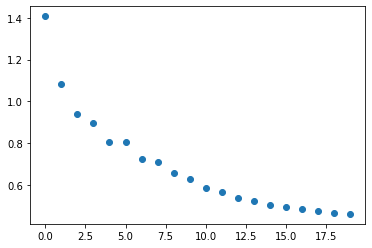

In [22]:
w_new = train_model(W_new, x_new_train, y_new_train, itera = 20)

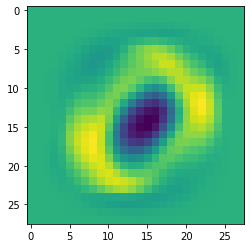

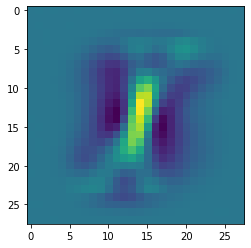

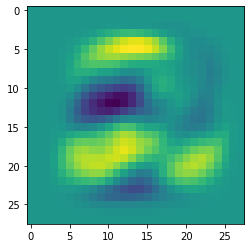

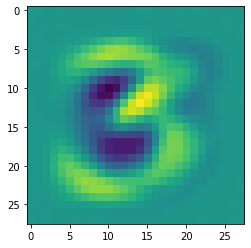

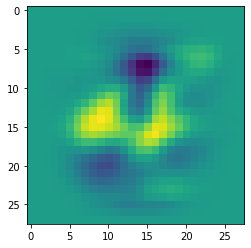

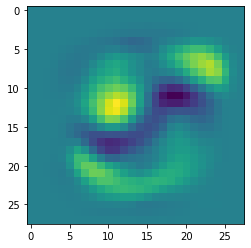

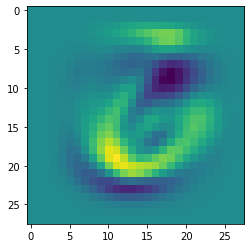

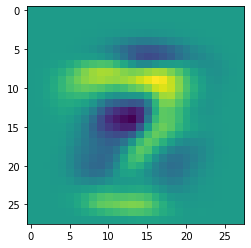

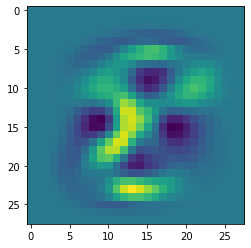

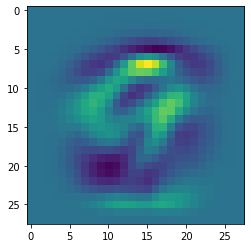

In [23]:
plot4 = []
for i in range(10):
    plot4.append(w_new.T[i][1:])
for i in range(10):
    plt.imshow(np.reshape(plot4[i],(28,28)))
    plt.show()